In [58]:
from google.colab import drive, output

# drive.mount('/content/drive')
 
%cd "/content"
!rm -rf traffic_sign_detection
!git clone https://github.com/ptran1203/traffic_sign_detection
%cd traffic_sign_detection
output.clear()

In [59]:
# !./download_data.sh
# !python3 train.py --input /content/dataset/za_traffic_2020/traffic_train/images\
#                   --backbone resnet50\
#                   --batch-size 4\
#                   --checkpoint-dir /content/weights\
#                   --init-from weights/weight_resnet50.h5\

In [60]:
!python3 prediction.py --input /content/traffic_sign_detection/images/0.png\
                       --output /content/submission.json\
                       --weight weights/weight_densenet121.h5\
                       --scales 1024
                      #  --tiling\
                      #  --weight /content/traffic_sign_detection/weights/weight_densenet121.h5

SyntaxError: ignored

In [61]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import os.path as path
def undistort(frame, mtx, dist, verbose=False):
    """
    Undistort a frame given camera matrix and distortion coefficients.
    :param frame: input frame
    :param mtx: camera matrix
    :param dist: distortion coefficients
    :param verbose: if True, show frame before/after distortion correction
    :return: undistorted frame
    """
    frame_undistorted = cv2.undistort(frame, mtx, dist, newCameraMatrix=mtx)

    if verbose:
        fig, ax = plt.subplots(nrows=1, ncols=2)
        ax[0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        ax[1].imshow(cv2.cvtColor(frame_undistorted, cv2.COLOR_BGR2RGB))
        plt.show()

    return frame_undistorted

def calibrate_camera(calib_images_dir, verbose=False):

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6 * 9, 3), np.float32)

    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)
    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d points in real world space
    imgpoints = []  # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(path.join(calib_images_dir, 'calibration*.jpg'))
    # Step through the list and search for chessboard corners
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    gray=None
    for filename in images:
        temp_img= cv2.imread(filename)
        img = cv2.imread(filename)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        pattern_found, corners = cv2.findChessboardCorners(gray, (9, 6), None)
        cv2.findChessboardCorners(gray, (9,6),cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
        if pattern_found is True:
            objpoints.append(objp)
            corners2=cv2.cornerSubPix(gray, corners, (11,11),(-1,-1), criteria)
            imgpoints.append(corners2)

            if verbose:
                # Draw and display the corners
                img = cv2.drawChessboardCorners(img, (9, 6), corners, pattern_found)
                cv2.imshow('img',img)
                cv2.waitKey(5000)

    # if verbose:
    #     cv2.destroyAllWindows()

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    return ret, mtx, dist, rvecs, tvecs


In [55]:
ret, mtx, dist, rvecs, tvecs = calibrate_camera(calib_images_dir='/content/camera_cal')


In [31]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt


# selected threshold to highlight yellow lines
yellow_HSV_th_min = np.array([0, 70, 70])
yellow_HSV_th_max = np.array([50, 255, 255])


def thresh_frame_in_HSV(frame, min_values, max_values, verbose=False):
    """
    Threshold a color frame in HSV space
    """
    HSV = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    min_th_ok = np.all(HSV > min_values, axis=2)
    max_th_ok = np.all(HSV < max_values, axis=2)

    out = np.logical_and(min_th_ok, max_th_ok)

    if verbose:
        plt.imshow(out, cmap='gray')
        plt.show()

    return out


def thresh_frame_sobel(frame, kernel_size):
    """
    Apply Sobel edge detection to an input frame, then threshold the result
    """
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)

    sobel_mag = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    sobel_mag = np.uint8(sobel_mag / np.max(sobel_mag) * 255)

    _, sobel_mag = cv2.threshold(sobel_mag, 50, 1, cv2.THRESH_BINARY)

    return sobel_mag.astype(bool)


def get_binary_from_equalized_grayscale(frame):
    """
    Apply histogram equalization to an input frame, threshold it and return the (binary) result.
    """
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    eq_global = cv2.equalizeHist(gray)

    _, th = cv2.threshold(eq_global, thresh=250, maxval=255, type=cv2.THRESH_BINARY)

    return th


def binarize(img, verbose=False):
    """
    Convert an input frame to a binary image which highlight as most as possible the lane-lines.
    :param img: input color frame
    :param verbose: if True, show intermediate results
    :return: binarized frame
    """
    h, w = img.shape[:2]

    binary = np.zeros(shape=(h, w), dtype=np.uint8)

    # highlight yellow lines by threshold in HSV color space
    HSV_yellow_mask = thresh_frame_in_HSV(img, yellow_HSV_th_min, yellow_HSV_th_max, verbose=False)
    binary = np.logical_or(binary, HSV_yellow_mask)

    # highlight white lines by thresholding the equalized frame
    eq_white_mask = get_binary_from_equalized_grayscale(img)
    binary = np.logical_or(binary, eq_white_mask)

    # get Sobel binary mask (thresholded gradients)
    sobel_mask = thresh_frame_sobel(img, kernel_size=9)
    binary = np.logical_or(binary, sobel_mask)

    # apply a light morphology to "fill the gaps" in the binary image
    kernel = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(binary.astype(np.uint8), cv2.MORPH_CLOSE, kernel)

    if verbose:
        f, ax = plt.subplots(2, 3)
        f.set_facecolor('white')
        ax[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax[0, 0].set_title('input_frame')
        ax[0, 0].set_axis_off()
        ax[0, 0].set_facecolor('red')
        ax[0, 1].imshow(eq_white_mask, cmap='gray')
        ax[0, 1].set_title('white mask')
        ax[0, 1].set_axis_off()

        ax[0, 2].imshow(HSV_yellow_mask, cmap='gray')
        ax[0, 2].set_title('yellow mask')
        ax[0, 2].set_axis_off()

        ax[1, 0].imshow(sobel_mask, cmap='gray')
        ax[1, 0].set_title('sobel mask')
        ax[1, 0].set_axis_off()

        ax[1, 1].imshow(binary, cmap='gray')
        ax[1, 1].set_title('before closure')
        ax[1, 1].set_axis_off()

        ax[1, 2].imshow(closing, cmap='gray')
        ax[1, 2].set_title('after closure')
        ax[1, 2].set_axis_off()
        plt.show()

    return closing

In [32]:

  
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
# from calibration_utils import calibrate_camera, undistort
# from binarization_utils import binarize


def birdeye(img, verbose=False):
    """
    Apply perspective transform to input frame to get the bird's eye view.
    :param img: input color frame
    :param verbose: if True, show the transformation result
    :return: warped image, and both forward and backward transformation matrices
    """
    h, w = img.shape[:2]

    src = np.float32([[w, h-10],    # br
                      [0, h-10],    # bl
                      [546, 460],   # tl
                      [732, 460]])  # tr
    dst = np.float32([[w, h],       # br
                      [0, h],       # bl
                      [0, 0],       # tl
                      [w, 0]])      # tr

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(img, M, (w, h), flags=cv2.INTER_LINEAR)

    if verbose:
        f, axarray = plt.subplots(1, 2)
        f.set_facecolor('white')
        axarray[0].set_title('Before perspective transform')
        axarray[0].imshow(img, cmap='gray')
        for point in src:
            axarray[0].plot(*point, '.')
        axarray[1].set_title('After perspective transform')
        axarray[1].imshow(warped, cmap='gray')
        for point in dst:
            axarray[1].plot(*point, '.')
        for axis in axarray:
            axis.set_axis_off()
        plt.show()

    return warped, M, Minv


In [33]:
ym_per_pix = 30 / 720   # meters per pixel in y dimension
xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

time_window = 10        # results are averaged over this number of frames




In [35]:
import numpy as np
import cv2
import glob
import collections
import matplotlib.pyplot as plt


class Line:
    """
    Class to model a lane-line.
    """
    def __init__(self, buffer_len=10):

        # flag to mark if the line was detected the last iteration
        self.detected = False

        # polynomial coefficients fitted on the last iteration
        self.last_fit_pixel = None
        self.last_fit_meter = None

        # list of polynomial coefficients of the last N iterations
        self.recent_fits_pixel = collections.deque(maxlen=buffer_len)
        self.recent_fits_meter = collections.deque(maxlen=2 * buffer_len)

        self.radius_of_curvature = None

        # store all pixels coords (x, y) of line detected
        self.all_x = None
        self.all_y = None

    def update_line(self, new_fit_pixel, new_fit_meter, detected, clear_buffer=False):
        """
        Update Line with new fitted coefficients.
        :param new_fit_pixel: new polynomial coefficients (pixel)
        :param new_fit_meter: new polynomial coefficients (meter)
        :param detected: if the Line was detected or inferred
        :param clear_buffer: if True, reset state
        :return: None
        """
        self.detected = detected

        if clear_buffer:
            self.recent_fits_pixel = []
            self.recent_fits_meter = []

        self.last_fit_pixel = new_fit_pixel
        self.last_fit_meter = new_fit_meter

        self.recent_fits_pixel.append(self.last_fit_pixel)
        self.recent_fits_meter.append(self.last_fit_meter)

    def draw(self, mask, color=(255, 0, 0), line_width=50, average=False):
        """
        Draw the line on a color mask image.
        """
        h, w, c = mask.shape

        plot_y = np.linspace(0, h - 1, h)
        coeffs = self.average_fit if average else self.last_fit_pixel

        line_center = coeffs[0] * plot_y ** 2 + coeffs[1] * plot_y + coeffs[2]
        line_left_side = line_center - line_width // 2
        line_right_side = line_center + line_width // 2

        # Some magic here to recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array(list(zip(line_left_side, plot_y)))
        pts_right = np.array(np.flipud(list(zip(line_right_side, plot_y))))
        pts = np.vstack([pts_left, pts_right])

        # Draw the lane onto the warped blank image
        return cv2.fillPoly(mask, [np.int32(pts)], color)

    @property
    # average of polynomial coefficients of the last N iterations
    def average_fit(self):
        return np.mean(self.recent_fits_pixel, axis=0)

    @property
    # radius of curvature of the line (averaged)
    def curvature(self):
        y_eval = 0
        coeffs = self.average_fit
        return ((1 + (2 * coeffs[0] * y_eval + coeffs[1]) ** 2) ** 1.5) / np.absolute(2 * coeffs[0])

    @property
    # radius of curvature of the line (averaged)
    def curvature_meter(self):
        y_eval = 0
        coeffs = np.mean(self.recent_fits_meter, axis=0)
        return ((1 + (2 * coeffs[0] * y_eval + coeffs[1]) ** 2) ** 1.5) / np.absolute(2 * coeffs[0])


def get_fits_by_sliding_windows(birdeye_binary, line_lt, line_rt, n_windows=9, verbose=False):
    """
    Get polynomial coefficients for lane-lines detected in an binary image.
    :param birdeye_binary: input bird's eye view binary image
    :param line_lt: left lane-line previously detected
    :param line_rt: left lane-line previously detected
    :param n_windows: number of sliding windows used to search for the lines
    :param verbose: if True, display intermediate output
    :return: updated lane lines and output image
    """
    height, width = birdeye_binary.shape

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(birdeye_binary[height//2:-30, :], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((birdeye_binary, birdeye_binary, birdeye_binary)) * 255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = len(histogram) // 2
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(height / n_windows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = birdeye_binary.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    margin = 100  # width of the windows +/- margin
    minpix = 50   # minimum number of pixels found to recenter window

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(n_windows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = height - (window + 1) * window_height
        win_y_high = height - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_xleft_low)
                          & (nonzero_x < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_xright_low)
                           & (nonzero_x < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzero_x[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzero_x[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    line_lt.all_x, line_lt.all_y = nonzero_x[left_lane_inds], nonzero_y[left_lane_inds]
    line_rt.all_x, line_rt.all_y = nonzero_x[right_lane_inds], nonzero_y[right_lane_inds]

    detected = True
    if not list(line_lt.all_x) or not list(line_lt.all_y):
        left_fit_pixel = line_lt.last_fit_pixel
        left_fit_meter = line_lt.last_fit_meter
        detected = False
    else:
        left_fit_pixel = np.polyfit(line_lt.all_y, line_lt.all_x, 2)
        left_fit_meter = np.polyfit(line_lt.all_y * ym_per_pix, line_lt.all_x * xm_per_pix, 2)

    if not list(line_rt.all_x) or not list(line_rt.all_y):
        right_fit_pixel = line_rt.last_fit_pixel
        right_fit_meter = line_rt.last_fit_meter
        detected = False
    else:
        right_fit_pixel = np.polyfit(line_rt.all_y, line_rt.all_x, 2)
        right_fit_meter = np.polyfit(line_rt.all_y * ym_per_pix, line_rt.all_x * xm_per_pix, 2)

    line_lt.update_line(left_fit_pixel, left_fit_meter, detected=detected)
    line_rt.update_line(right_fit_pixel, right_fit_meter, detected=detected)

    # Generate x and y values for plotting
    ploty = np.linspace(0, height - 1, height)
    left_fitx = left_fit_pixel[0] * ploty ** 2 + left_fit_pixel[1] * ploty + left_fit_pixel[2]
    right_fitx = right_fit_pixel[0] * ploty ** 2 + right_fit_pixel[1] * ploty + right_fit_pixel[2]

    out_img[nonzero_y[left_lane_inds], nonzero_x[left_lane_inds]] = [255, 0, 0]
    out_img[nonzero_y[right_lane_inds], nonzero_x[right_lane_inds]] = [0, 0, 255]

    if verbose:
        f, ax = plt.subplots(1, 2)
        f.set_facecolor('white')
        ax[0].imshow(birdeye_binary, cmap='gray')
        ax[1].imshow(out_img)
        ax[1].plot(left_fitx, ploty, color='yellow')
        ax[1].plot(right_fitx, ploty, color='yellow')
        ax[1].set_xlim(0, 1280)
        ax[1].set_ylim(720, 0)

        plt.show()

    return line_lt, line_rt, out_img


def get_fits_by_previous_fits(birdeye_binary, line_lt, line_rt, verbose=False):
    """
    Get polynomial coefficients for lane-lines detected in an binary image.
    This function starts from previously detected lane-lines to speed-up the search of lane-lines in the current frame.
    :param birdeye_binary: input bird's eye view binary image
    :param line_lt: left lane-line previously detected
    :param line_rt: left lane-line previously detected
    :param verbose: if True, display intermediate output
    :return: updated lane lines and output image
    """

    height, width = birdeye_binary.shape

    left_fit_pixel = line_lt.last_fit_pixel
    right_fit_pixel = line_rt.last_fit_pixel

    nonzero = birdeye_binary.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    margin = 100
    left_lane_inds = (
    (nonzero_x > (left_fit_pixel[0] * (nonzero_y ** 2) + left_fit_pixel[1] * nonzero_y + left_fit_pixel[2] - margin)) & (
    nonzero_x < (left_fit_pixel[0] * (nonzero_y ** 2) + left_fit_pixel[1] * nonzero_y + left_fit_pixel[2] + margin)))
    right_lane_inds = (
    (nonzero_x > (right_fit_pixel[0] * (nonzero_y ** 2) + right_fit_pixel[1] * nonzero_y + right_fit_pixel[2] - margin)) & (
    nonzero_x < (right_fit_pixel[0] * (nonzero_y ** 2) + right_fit_pixel[1] * nonzero_y + right_fit_pixel[2] + margin)))

    # Extract left and right line pixel positions
    line_lt.all_x, line_lt.all_y = nonzero_x[left_lane_inds], nonzero_y[left_lane_inds]
    line_rt.all_x, line_rt.all_y = nonzero_x[right_lane_inds], nonzero_y[right_lane_inds]

    detected = True
    if not list(line_lt.all_x) or not list(line_lt.all_y):
        left_fit_pixel = line_lt.last_fit_pixel
        left_fit_meter = line_lt.last_fit_meter
        detected = False
    else:
        left_fit_pixel = np.polyfit(line_lt.all_y, line_lt.all_x, 2)
        left_fit_meter = np.polyfit(line_lt.all_y * ym_per_pix, line_lt.all_x * xm_per_pix, 2)

    if not list(line_rt.all_x) or not list(line_rt.all_y):
        right_fit_pixel = line_rt.last_fit_pixel
        right_fit_meter = line_rt.last_fit_meter
        detected = False
    else:
        right_fit_pixel = np.polyfit(line_rt.all_y, line_rt.all_x, 2)
        right_fit_meter = np.polyfit(line_rt.all_y * ym_per_pix, line_rt.all_x * xm_per_pix, 2)

    line_lt.update_line(left_fit_pixel, left_fit_meter, detected=detected)
    line_rt.update_line(right_fit_pixel, right_fit_meter, detected=detected)

    # Generate x and y values for plotting
    ploty = np.linspace(0, height - 1, height)
    left_fitx = left_fit_pixel[0] * ploty ** 2 + left_fit_pixel[1] * ploty + left_fit_pixel[2]
    right_fitx = right_fit_pixel[0] * ploty ** 2 + right_fit_pixel[1] * ploty + right_fit_pixel[2]

    # Create an image to draw on and an image to show the selection window
    img_fit = np.dstack((birdeye_binary, birdeye_binary, birdeye_binary)) * 255
    window_img = np.zeros_like(img_fit)

    # Color in left and right line pixels
    img_fit[nonzero_y[left_lane_inds], nonzero_x[left_lane_inds]] = [255, 0, 0]
    img_fit[nonzero_y[right_lane_inds], nonzero_x[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
    result = cv2.addWeighted(img_fit, 1, window_img, 0.3, 0)

    if verbose:
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

        plt.show()

    return line_lt, line_rt, img_fit


def draw_back_onto_the_road(img_undistorted, Minv, line_lt, line_rt, keep_state):
    """
    Draw both the drivable lane area and the detected lane-lines onto the original (undistorted) frame.
    :param img_undistorted: original undistorted color frame
    :param Minv: (inverse) perspective transform matrix used to re-project on original frame
    :param line_lt: left lane-line previously detected
    :param line_rt: right lane-line previously detected
    :param keep_state: if True, line state is maintained
    :return: color blend
    """
    height, width, _ = img_undistorted.shape
    left_fit = line_lt.average_fit if keep_state else line_lt.last_fit_pixel
    right_fit = line_rt.average_fit if keep_state else line_rt.last_fit_pixel

    # Generate x and y values for plotting
    ploty = np.linspace(0, height - 1, height)
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    # draw road as green polygon on original frame
    road_warp = np.zeros_like(img_undistorted, dtype=np.uint8)
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(road_warp, np.int_([pts]), (0, 255, 0))
    road_dewarped = cv2.warpPerspective(road_warp, Minv, (width, height))  # Warp back to original image space

    blend_onto_road = cv2.addWeighted(img_undistorted, 1., road_dewarped, 0.3, 0)


    # now separately draw solid lines to highlight them
    line_warp = np.zeros_like(img_undistorted)
    line_warp = line_lt.draw(line_warp, color=(255, 0, 0), average=keep_state)
    line_warp = line_rt.draw(line_warp, color=(0, 0, 255), average=keep_state)
    line_dewarped = cv2.warpPerspective(line_warp, Minv, (width, height))

    lines_mask = blend_onto_road.copy()

    idx = np.any([line_dewarped != 0][0], axis=2)
    lines_mask[idx] = line_dewarped[idx]

    blend_onto_road = cv2.addWeighted(src1=lines_mask, alpha=0.8, src2=blend_onto_road, beta=0.5, gamma=0.)

    return blend_onto_road

In [36]:
import cv2
import os
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
import numpy as np


processed_frames = 0                    # counter of frames processed (when processing video)
line_lt = Line(buffer_len=time_window)  # line on the left of the lane
line_rt = Line(buffer_len=time_window)  # line on the right of the lane


def prepare_out_blend_frame(blend_on_road, img_binary, img_birdeye, img_fit, line_lt, line_rt, offset_meter):
    """
    Prepare the final pretty pretty output blend, given all intermediate pipeline images
    :param blend_on_road: color image of lane blend onto the road
    :param img_binary: thresholded binary image
    :param img_birdeye: bird's eye view of the thresholded binary image
    :param img_fit: bird's eye view with detected lane-lines highlighted
    :param line_lt: detected left lane-line
    :param line_rt: detected right lane-line
    :param offset_meter: offset from the center of the lane
    :return: pretty blend with all images and stuff stitched
    """
    
    h, w = blend_on_road.shape[:2]

    thumb_ratio = 0.2
    thumb_h, thumb_w = int(thumb_ratio * h), int(thumb_ratio * w)

    off_x, off_y = 20, 15

    # add a gray rectangle to highlight the upper area
    mask = blend_on_road.copy()
    mask = cv2.rectangle(mask, pt1=(0, 0), pt2=(w, thumb_h+2*off_y), color=(0, 0, 0), thickness=cv2.FILLED)
    blend_on_road = cv2.addWeighted(src1=mask, alpha=0.2, src2=blend_on_road, beta=0.8, gamma=0)

    # add thumbnail of binary image
    thumb_binary = cv2.resize(img_binary, dsize=(thumb_w, thumb_h))
    thumb_binary = np.dstack([thumb_binary, thumb_binary, thumb_binary]) * 255
    blend_on_road[off_y:thumb_h+off_y, off_x:off_x+thumb_w, :] = thumb_binary

    # add thumbnail of bird's eye view
    thumb_birdeye = cv2.resize(img_birdeye, dsize=(thumb_w, thumb_h))
    thumb_birdeye = np.dstack([thumb_birdeye, thumb_birdeye, thumb_birdeye]) * 255
    blend_on_road[off_y:thumb_h+off_y, 2*off_x+thumb_w:2*(off_x+thumb_w), :] = thumb_birdeye

    # add thumbnail of bird's eye view (lane-line highlighted)
    thumb_img_fit = cv2.resize(img_fit, dsize=(thumb_w, thumb_h))
    blend_on_road[off_y:thumb_h+off_y, 3*off_x+2*thumb_w:3*(off_x+thumb_w), :] = thumb_img_fit

    # add text (curvature and offset info) on the upper right of the blend
    mean_curvature_meter = np.mean([line_lt.curvature_meter, line_rt.curvature_meter])
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(blend_on_road, 'Curvature radius: {:.02f}m'.format(mean_curvature_meter), (860, 60), font, 0.9, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(blend_on_road, 'Offset from center: {:.02f}m'.format(offset_meter), (860, 130), font, 0.9, (255, 255, 255), 2, cv2.LINE_AA)

    return blend_on_road


def compute_offset_from_center(line_lt, line_rt, frame_width):
    """
    Compute offset from center of the inferred lane.
    The offset from the lane center can be computed under the hypothesis that the camera is fixed
    and mounted in the midpoint of the car roof. In this case, we can approximate the car's deviation
    from the lane center as the distance between the center of the image and the midpoint at the bottom
    of the image of the two lane-lines detected.
    :param line_lt: detected left lane-line
    :param line_rt: detected right lane-line
    :param frame_width: width of the undistorted frame
    :return: inferred offset
    """
    if line_lt.detected and line_rt.detected:
        line_lt_bottom = np.mean(line_lt.all_x[line_lt.all_y > 0.95 * line_lt.all_y.max()])
        line_rt_bottom = np.mean(line_rt.all_x[line_rt.all_y > 0.95 * line_rt.all_y.max()])
        lane_width = line_rt_bottom - line_lt_bottom
        midpoint = frame_width / 2
        offset_pix = abs((line_lt_bottom + lane_width / 2) - midpoint)
        offset_meter = xm_per_pix * offset_pix
    else:
        offset_meter = -1

    return offset_meter


def process_pipeline(frame, keep_state=True):
    """
    Apply whole lane detection pipeline to an input color frame.
    :param frame: input color frame
    :param keep_state: if True, lane-line state is conserved (this permits to average results)
    :return: output blend with detected lane overlaid
    """

    global line_lt, line_rt, processed_frames

    # undistort the image using coefficients found in calibration
    img_undistorted = undistort(frame, mtx, dist, verbose=False)
    # binarize the frame s.t. lane lines are highlighted as much as possible
    img_binary = binarize(img_undistorted, verbose=False)

    # compute perspective transform to obtain bird's eye view
    img_birdeye, M, Minv = birdeye(img_binary, verbose=False)

    # fit 2-degree polynomial curve onto lane lines found
    if processed_frames > 0 and keep_state and line_lt.detected and line_rt.detected:
        line_lt, line_rt, img_fit = get_fits_by_previous_fits(img_birdeye, line_lt, line_rt, verbose=False)
    else:
        line_lt, line_rt, img_fit = get_fits_by_sliding_windows(img_birdeye, line_lt, line_rt, n_windows=9, verbose=False)

    # compute offset in meter from center of the lane
    offset_meter = compute_offset_from_center(line_lt, line_rt, frame_width=frame.shape[1])
    # draw the surface enclosed by lane lines back onto the original frame
    blend_on_road = draw_back_onto_the_road(frame, Minv, line_lt, line_rt, keep_state)

    # stitch on the top of final output images from different steps of the pipeline
    blend_output = prepare_out_blend_frame(blend_on_road, img_binary, img_birdeye, img_fit, line_lt, line_rt, offset_meter)

    processed_frames += 1

    return blend_on_road


In [37]:
from prediction import get_inference_model, Prediction
import cv2
import utils


In [67]:
ret, mtx, dist, rvecs, tvecs = calibrate_camera(calib_images_dir='/content/camera_cal')

test_img_dir = 'test_images'
weight = 'weights/weight_densenet121.h5'
backbone = weight.split("_")[-1].replace(".h5", "")

predictor = Prediction(get_inference_model(weight, backbone))

In [80]:
def check_class(classess):
  LABEL_MAP = {
    1: "No entry",
    2: "No parking / waiting",
    3: "No turning",
    4: "Max Speed",
    5: "Other prohibition signs",
    6: "Warning",
    7: "Mandatory",
}
  for c in classes:
    if(c==1):
      print("1: No entry")
    elif(c==2):
      print("2: No parking / waiting")
    elif(c==3):
      print("3: No turning")
    elif(c==4):
      print("4: Max Speed") 
    elif(c==5):
      print("5: Other prohibition signs") 
    elif(c==6):
      print("6: Warning") 
    elif(c==7):
      print("7: Mandatory")

      
      



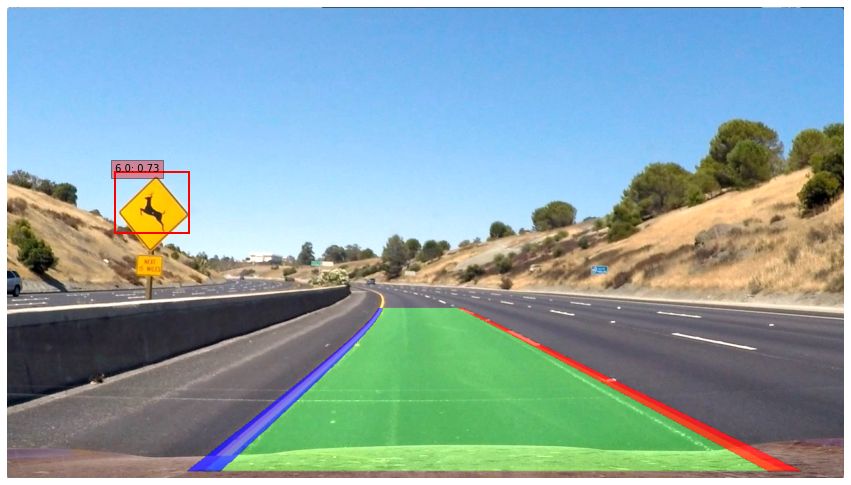

6: Warning


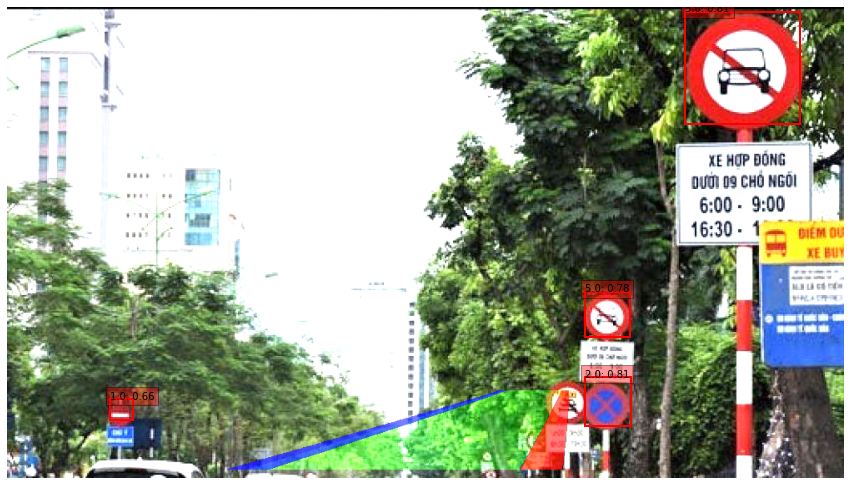

5: Other prohibition signs
2: No parking / waiting
5: Other prohibition signs
1: No entry


error: ignored

In [82]:

for test_img in os.listdir(test_img_dir):
  frame = cv2.imread(os.path.join(test_img_dir, test_img))
  blend = process_pipeline(frame, keep_state=False)
  cv2.imwrite('output_images/{}'.format(test_img), blend)
  # plt.imshow(cv2.cvtColor(blend, code=cv2.COLOR_BGR2RGB))
  # plt.show()
  image, boxes, scores, classes = predictor.detect_single_image(
        blend[..., ::-1], tiling=False)
  classes_array=classes.numpy()
  classes_array=classes_array.astype(int)
  utils.visualize_detections(image, boxes, classes, scores)
  check_class(classes_array)  

